In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gradient-descent/AI-InvestorFinalProjectPart2.docx
/kaggle/input/gradient-descent/sample_submission.csv
/kaggle/input/gradient-descent/bureau_balance.csv
/kaggle/input/gradient-descent/POS_CASH_balance.csv
/kaggle/input/gradient-descent/application_train.csv
/kaggle/input/gradient-descent/HomeCredit_columns_description.csv
/kaggle/input/gradient-descent/AI-InvestorFinalProject.docx
/kaggle/input/gradient-descent/application_test.csv
/kaggle/input/gradient-descent/previous_application.csv
/kaggle/input/gradient-descent/constituents_csv.csv
/kaggle/input/gradient-descent/credit_card_balance.csv
/kaggle/input/gradient-descent/installments_payments.csv
/kaggle/input/gradient-descent/bureau.csv


In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/kaggle/input/gradient-descent/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/kaggle/input/gradient-descent/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


In [4]:
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#https://catboost.ai/en/docs/concepts/python-reference_utils_get_roc_curve
#https://www.kaggle.com/code/romantihiy/catboost-0-96-auc/notebook

Train samples: 307511, test samples: 48744
Starting catBoost. Train shape: (307507, 248), test shape: (48744, 248)
[07:38:20] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy of the catboost:  0.919455753996644
Test ROC AUC = 0.5092148049827541
Train ROC AUC = 0.5214622671983993
[[141122    219]
 [ 12165    248]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    141341
         1.0       0.53      0.02      0.04     12413

    accuracy                           0.92    153754
   macro avg       0.73      0.51      0.50    153754
weighted avg       0.89      0.92      0.88    153754

[07:58:27] WARNING: ../src/learner.cc:627: 
Paramete

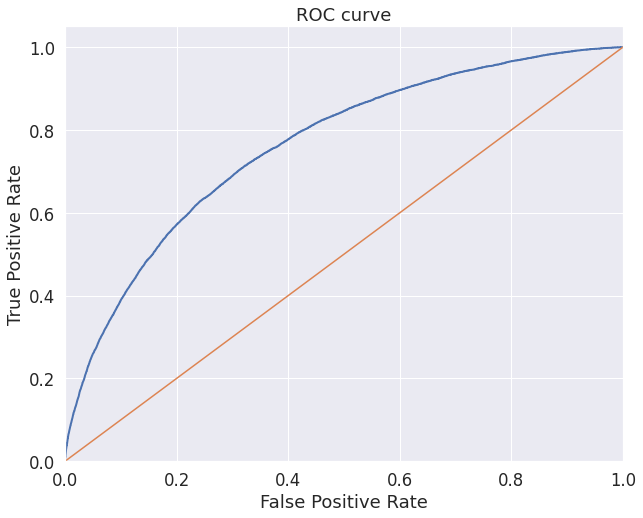

['_Booster', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_can_use_inplace_predict', '_check_feature_names', '_check_n_features', '_configure_fit', '_early_stopping_attr', '_estimator_type', '_get_iteration_range', '_get_param_names', '_get_tags', '_get_type', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_set_evaluation_result', '_validate_data', 'apply', 'base_score', 'best_iteration', 'best_ntree_limit', 'best_score', 'booster', 'callbacks', 'classes_', 'coef_', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'evals_result', 'feature_

In [5]:

# Catboost with KFold or Stratified KFold

def kfold_catboost(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting catBoost. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        """
        catClf = CatBoostClassifier(
            iterations=15, 
            learning_rate=0.5, 
            loss_function='CrossEntropy'
        )
        """
        # A parameter grid for XGBoost
        params = {
       # 'min_child_weight': [1, 5, 10],
       # 'gamma': [0.5, 1, 1.5, 2, 5],
       # 'subsample': [0.6, 0.8, 1.0],
       # 'colsample_bytree': [0.6, 0.8, 1.0],
        #'max_depth': [3, 4, 5]
        }
        folds = 3
        param_comb = 5

        xgb = XGBClassifier(eval_metric='auc', learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
        #random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, X=train_x, y=train_y verbose=3, random_state=1001 )

        """
        catClf = CatBoostClassifier()
        grid = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10],
                'l2_leaf_reg': [1, 3, 5, 7, 9]}
        catClf.randomized_search(grid, X=train_x, y=train_y)
        
        catClf.fit(train_x, train_y)
        predictions = catClf.predict(valid_x)
        predictionsTrain = catClf.predict(train_x)
        """
        xgb.fit(train_x, train_y)
        predictions = xgb.predict(valid_x)
        predictionsTrain = xgb.predict(train_x)
        print("accuracy of the catboost: ",accuracy_score(valid_y,predictions))
        print('Test ROC AUC =', roc_auc_score(valid_y, predictions))
        print('Train ROC AUC =', roc_auc_score(train_y, predictionsTrain))
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report
        cm = confusion_matrix(valid_y, predictions)
        print(cm)

        cr = classification_report(valid_y, predictions)
        print(cr) 
        
       
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(valid_y, xgb.predict_proba(valid_x)[:,1], pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    print(dir(xgb))
        
    return xgb

def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    """
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    """
    with timer("Run LightGBM with kfold"):
        model = kfold_catboost(df, num_folds= 2, stratified= False, debug= debug)

#if __name__ == "__main__":
submission_file_name = "submission_kernel02.csv"
with timer("Full model run"):
   
    main()